# Imports

In [ ]:
# ============================================================================
# 03_modeling.py
# Modeling and Evaluation for Diabetes Binary Classification
# Extended with Hyperparameter Tuning (RandomizedSearchCV), Multiple Models, ANN, and Decision Curve Analysis (DCA)
# Integrated with preprocessing module
# ============================================================================
"""
Notes:
- RandomizedSearchCV is used for efficiency.
- For expensive models (RF, XGBoost) tuning runs on a 30% subsample, then the best estimator is refit on the full training set.
- CV for RandomizedSearchCV is set to cv=5 as requested.
- MLP tuning uses early stopping and reduced max_iter for speed.
- Best models are saved to disk for use in 04_results.py
"""

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys  # noqa: F401
import os  # noqa: F401
import warnings
import joblib
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier  # noqa: E402
from sklearn.linear_model import LogisticRegression  # noqa: E402
from sklearn.svm import LinearSVC  # noqa: E402
from sklearn.neighbors import KNeighborsClassifier  # noqa: E402
from sklearn.naive_bayes import GaussianNB  # noqa: E402
from sklearn.tree import DecisionTreeClassifier  # noqa: E402
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score  # noqa: E402, F401
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split  # noqa: E402
from sklearn.calibration import CalibratedClassifierCV  # noqa: E402
from sklearn.metrics import precision_recall_curve, average_precision_score  # noqa: E402
from sklearn.neural_network import MLPClassifier  # noqa: E402

import xgboost as xgb  # noqa: E402

from scipy.stats import randint, uniform  # noqa: E402, F401

from pathlib import Path  # noqa: E402


# Load Preprocessed Data

In [61]:
# ============================================================================
# 1. LOAD PREPROCESSED DATA
# ============================================================================
print("="*80)
print("LOAD PREPROCESSED DATA")
print("="*80)

try:
    models_dir = Path(r"C:\Users\Eyyub\Desktop\StackFuel\PortfolioProjekt\DPP-Stackfuel-Data-Science-Projekt\models")

    features_train = joblib.load(models_dir / "features_train.pkl")
    target_train = joblib.load(models_dir / "target_train.pkl")
    features_test = joblib.load(models_dir / "features_test.pkl")
    target_test = joblib.load(models_dir / "target_test.pkl")
    feature_names_original = joblib.load(models_dir / "feature_names.pkl")
    preprocessor = joblib.load(models_dir / "preprocessor.pkl")

    print(f"Training set size: {len(features_train):,}")
    print(f"Test set size: {len(features_test):,}")
    print(f"Number of features: {features_train.shape[1]}")
    PREPROCESSING_AVAILABLE = True

except Exception as e:
    print(f"Error loading preprocessed data: {e}")
    PREPROCESSING_AVAILABLE = False

LOAD PREPROCESSED DATA
Training set size: 311,002
Test set size: 45,895
Number of features: 51


# Model Initialization

In [62]:
# ============================================================================
# 2. MODEL INITIALIZATION (base estimators)
# ============================================================================
print("\n" + "="*80)
print("MODEL INITIALIZATION (BASE ESTIMATORS)")
print("="*80)

base_estimators = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    # Use LinearSVC as base; wrap in CalibratedClassifierCV later if you need probabilities
    'SVM': CalibratedClassifierCV(LinearSVC(random_state=42, max_iter=10000, dual=False), cv=5),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(random_state=42, max_iter=500)
}



MODEL INITIALIZATION (BASE ESTIMATORS)


# Hyperparameter Tuning

In this section, hyperparameter tuning is performed only for four selected models:
Random Forest, XGBoost, Logistic Regression, and Neural Network.

The rationale behind this selective tuning approach is based on a balance between 
computational efficiency and expected impact on model performance:

1. Effectiveness of Hyperparameters:
   These four models have hyperparameters that significantly influence their 
   predictive performance. For example, the number of trees and depth in Random Forest,
   learning rate and tree depth in XGBoost, regularization strength in Logistic Regression,
   and architecture parameters in Neural Networks can greatly affect results.

2. Computational Cost:
   Exhaustive hyperparameter tuning (e.g., GridSearchCV) is computationally expensive,
   especially when applied to many models with large parameter grids. Focusing on 
   models with the highest potential gain optimizes resource usage.

3. Simplicity and Speed of Other Models:
   Other models like Decision Trees, K-Nearest Neighbors, Naive Bayes, and Linear SVM 
   typically have fewer or less impactful hyperparameters, or are inherently faster to train.
   Their default parameters often provide reasonable baseline performance.

4. Practical Workflow:
   This approach allows for a manageable and efficient modeling pipeline, prioritizing 
   tuning efforts where they are most likely to yield substantial improvements.

If desired, hyperparameter tuning can be extended to additional models using more 
efficient search strategies (e.g., RandomizedSearchCV) or by tuning a smaller subset 
of parameters to balance performance gains with computational cost.


In [63]:
# ============================================================================
# 3. HYPERPARAMETER TUNING (RandomizedSearchCV, CV=5)
# ============================================================================
print("\n" + "="*80)
print("HYPERPARAMETER TUNING")
print("Note: Tuning for expensive models (RF, XGBoost) runs on a 30% subsample to save time.")
print("="*80)

# Create a 30% subsample for expensive model tuning
features_sub, _, target_sub, _ = train_test_split(features_train, target_train, train_size=0.30, stratify=target_train, random_state=42)

# Parameter distributions for RandomizedSearch
param_distributions = {
    'Random Forest': {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [8, 12, 20, None],
        'min_samples_split': [2, 5, 10],
        'max_features': ['sqrt', 'log2', 0.5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0]
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
        'class_weight': [None, 'balanced']
    },
    'Neural Network': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive']
    }
}

# We will store the final trained models here
trained_models = {}




HYPERPARAMETER TUNING
Note: Tuning for expensive models (RF, XGBoost) runs on a 30% subsample to save time.


In [64]:
# Helper function to run RandomizedSearchCV and refit best estimator on full training set
def tune_and_refit(name, estimator, param_dist, features_tune, target_tune, features_full, target_full, n_iter=20, cv=5):
    """
    Tune estimator with RandomizedSearchCV on features_tune/target_tune (subsample for speed),
    then refit the best estimator on the full training data features_full/target_full.
    Returns the refitted best estimator and the best CV score.
    """
    print(f"[tuning] {name}: Starting RandomizedSearchCV (n_iter={n_iter}, cv={cv}) ...")
    rs = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='roc_auc',
        cv=cv,
        random_state=42,
        n_jobs=-1,
        verbose=1,
        refit=True
    )
    t0 = time.time()
    rs.fit(features_tune, target_tune)
    t1 = time.time()
    print(f"[tuning] {name}: RandomizedSearchCV finished in {(t1-t0)/60:.2f} min. Best CV score: {rs.best_score_:.4f}")
    print(f"[tuning] {name}: Best params: {rs.best_params_}")

    best_est = rs.best_estimator_
    print(f"[tuning] {name}: Refitting best estimator on the full training set ...")
    t2 = time.time()
    best_est.fit(features_full, target_full) # pyright: ignore[reportAttributeAccessIssue]
    t3 = time.time()
    print(f"[tuning] {name}: Refit finished in {(t3-t2)/60:.2f} min.")
    return best_est, rs.best_score_



In [65]:
# Random Forest tuning (on subsample, then refit on full)
if 'Random Forest' in base_estimators:
    rf_est = RandomForestClassifier(random_state=42, n_jobs=-1)
    rf_param_dist = param_distributions['Random Forest']
    best_rf, best_rf_score = tune_and_refit('Random Forest', rf_est, rf_param_dist, features_sub, target_sub, features_train, target_train, n_iter=12, cv=5)
    trained_models['Random Forest'] = best_rf



[tuning] Random Forest: Starting RandomizedSearchCV (n_iter=12, cv=5) ...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[tuning] Random Forest: RandomizedSearchCV finished in 10.34 min. Best CV score: 0.9544
[tuning] Random Forest: Best params: {'n_estimators': 50, 'min_samples_split': 2, 'max_features': 0.5, 'max_depth': None}
[tuning] Random Forest: Refitting best estimator on the full training set ...
[tuning] Random Forest: Refit finished in 1.01 min.


In [66]:
if 'XGBoost' in base_estimators:
    xgb_est = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
    xgb_param_dist = param_distributions['XGBoost']
    best_xgb, best_xgb_score = tune_and_refit('XGBoost', xgb_est, xgb_param_dist, features_sub, target_sub, features_train, target_train, n_iter=12, cv=5)
    trained_models['XGBoost'] = best_xgb




[tuning] XGBoost: Starting RandomizedSearchCV (n_iter=12, cv=5) ...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[tuning] XGBoost: RandomizedSearchCV finished in 2.31 min. Best CV score: 0.9636
[tuning] XGBoost: Best params: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1}
[tuning] XGBoost: Refitting best estimator on the full training set ...
[tuning] XGBoost: Refit finished in 0.27 min.


In [67]:
# Logistic Regression tuning
if 'Logistic Regression' in param_distributions:
    lr_est = LogisticRegression(random_state=42, max_iter=1000)
    lr_param_dist = param_distributions['Logistic Regression']
    best_lr, best_lr_score = tune_and_refit('Logistic Regression', lr_est, lr_param_dist, features_train, target_train, features_train, target_train, n_iter=12, cv=5)
    trained_models['Logistic Regression'] = best_lr



[tuning] Logistic Regression: Starting RandomizedSearchCV (n_iter=12, cv=5) ...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[tuning] Logistic Regression: RandomizedSearchCV finished in 2.98 min. Best CV score: 0.8142
[tuning] Logistic Regression: Best params: {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': None, 'C': 0.01}
[tuning] Logistic Regression: Refitting best estimator on the full training set ...
[tuning] Logistic Regression: Refit finished in 0.05 min.


In [68]:
# --- Neural Network tuning (MLP), FASTER VERSION ---
# Use a 30% subsample for tuning, enable early stopping, reduce max_iter, and reduce n_iter
if 'Neural Network' in param_distributions:
    # Subsample for MLP tuning
    features_sub_nn, _, target_sub_nn, _ = train_test_split(features_train, target_train, train_size=0.30, stratify=target_train, random_state=42)

    # Base estimator with early stopping and reduced iterations for tuning
    nn_est = MLPClassifier(random_state=42, max_iter=200, early_stopping=True, n_iter_no_change=10)

    nn_param_dist = param_distributions['Neural Network']

    # Randomized search with fewer iterations (n_iter=10) and cv=5
    best_nn, best_nn_score = tune_and_refit('Neural Network', nn_est, nn_param_dist, features_sub_nn, target_sub_nn, features_train, target_train, n_iter=10, cv=5)
    trained_models['Neural Network'] = best_nn
    



[tuning] Neural Network: Starting RandomizedSearchCV (n_iter=10, cv=5) ...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[tuning] Neural Network: RandomizedSearchCV finished in 14.54 min. Best CV score: 0.8813
[tuning] Neural Network: Best params: {'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.001, 'activation': 'relu'}
[tuning] Neural Network: Refitting best estimator on the full training set ...
[tuning] Neural Network: Refit finished in 2.55 min.


In [69]:
# For any remaining models not tuned, fit defaults on the full training set
for name, est in base_estimators.items():
    if name in trained_models:
        continue
    if est is None:
        continue
    print(f"[fit-default] Fitting default estimator for {name} on full training set ...")
    t0 = time.time()
    est.fit(features_train, target_train)
    t1 = time.time()
    print(f"[fit-default] {name} fitted in {(t1-t0)/60:.2f} min.")
    trained_models[name] = est


[fit-default] Fitting default estimator for SVM on full training set ...
[fit-default] SVM fitted in 0.18 min.
[fit-default] Fitting default estimator for K-Nearest Neighbors on full training set ...
[fit-default] K-Nearest Neighbors fitted in 0.00 min.
[fit-default] Fitting default estimator for Decision Tree on full training set ...
[fit-default] Decision Tree fitted in 0.13 min.
[fit-default] Fitting default estimator for Naive Bayes on full training set ...
[fit-default] Naive Bayes fitted in 0.00 min.


# Model Evaluation

In [70]:
# ============================================================================
# 4. MODEL EVALUATION WITH THRESHOLD OPTIMIZATION (F1)
# ============================================================================
print("\n" + "="*80)
print("MODEL EVALUATION WITH THRESHOLD OPTIMIZATION (F1)")
print("="*80)

model_results = {}
for name, model in trained_models.items():
    print(f"\nEvaluating {name} ...")
    # Ensure model supports predict_proba; if not, try to obtain calibrated probabilities
    try:
        y_proba = model.predict_proba(features_test)[:, 1]
    except Exception:
        # fallback: use decision_function and min-max scale (heuristic) - ideally calibrate with holdout
        if hasattr(model, "decision_function"):
            scores = model.decision_function(features_test)
            from sklearn.preprocessing import MinMaxScaler
            y_proba = MinMaxScaler().fit_transform(scores.reshape(-1, 1)).ravel()
        else:
            # last-resort: use predict (not ideal)
            y_proba = model.predict(features_test)

    # Schwellenwert-Optimierung (maximiert F1)
    precision_vals, recall_vals, thresholds = precision_recall_curve(target_test, y_proba)
    f1_vals = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-10)
    best_f1_idx = f1_vals.argmax()
    best_threshold = thresholds[best_f1_idx] if best_f1_idx < len(thresholds) else 0.5
    y_pred_opt = (y_proba >= best_threshold).astype(int)

    # Calculate all metrics
    auc_score = roc_auc_score(target_test, y_proba)
    precision = precision_score(target_test, y_pred_opt)
    recall = recall_score(target_test, y_pred_opt)
    f1 = f1_score(target_test, y_pred_opt)
    accuracy = accuracy_score(target_test, y_pred_opt)
    
    cv_scores = cross_val_score(model, features_train, target_train, cv=5, scoring='roc_auc', n_jobs=-1)

    model_results[name] = {
        'model': model,
        'y_pred': y_pred_opt,
        'y_proba': y_proba,
        'best_threshold': best_threshold,
        'auc': auc_score,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }

    print(f"AUC Score: {auc_score:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"CV AUC Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Best Threshold (F1): {best_threshold:.4f}")

# Identify best model by F1
best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['f1'])
best_model = model_results[best_model_name]['model']
best_y_proba = model_results[best_model_name]['y_proba']
best_threshold = model_results[best_model_name]['best_threshold']

print(f"\nBest model (by F1): {best_model_name} with F1: {model_results[best_model_name]['f1']:.4f}")


MODEL EVALUATION WITH THRESHOLD OPTIMIZATION (F1)

Evaluating Random Forest ...
AUC Score: 0.7634
Precision: 0.3239
Recall: 0.5977
F1 Score: 0.4201
Accuracy: 0.7477
CV AUC Score: 0.9707 (+/- 0.1088)
Best Threshold (F1): 0.2700

Evaluating XGBoost ...
AUC Score: 0.8154
Precision: 0.3701
Recall: 0.6424
F1 Score: 0.4696
Accuracy: 0.7781
CV AUC Score: 0.9555 (+/- 0.1696)
Best Threshold (F1): 0.2610

Evaluating Logistic Regression ...
AUC Score: 0.8084
Precision: 0.3785
Recall: 0.6021
F1 Score: 0.4648
Accuracy: 0.7880
CV AUC Score: 0.8142 (+/- 0.0097)
Best Threshold (F1): 0.6345

Evaluating Neural Network ...
AUC Score: 0.7700
Precision: 0.3245
Recall: 0.6093
F1 Score: 0.4235
Accuracy: 0.7462
CV AUC Score: 0.8967 (+/- 0.1248)
Best Threshold (F1): 0.4224

Evaluating SVM ...
AUC Score: 0.8084
Precision: 0.3696
Recall: 0.6242
F1 Score: 0.4643
Accuracy: 0.7797
CV AUC Score: 0.8139 (+/- 0.0097)
Best Threshold (F1): 0.6190

Evaluating K-Nearest Neighbors ...
AUC Score: 0.7153
Precision: 0.2788
R

# Saving Best Models

In [71]:
# ============================================================================
# 5. SAVE BEST MODELS
# ============================================================================
print("\n" + "="*80)
print("SAVE BEST MODELS")
print("="*80)

# Create models directory if it doesn't exist
models_dir = Path(r"C:\Users\Eyyub\Desktop\StackFuel\PortfolioProjekt\DPP-Stackfuel-Data-Science-Projekt\models")
models_dir.mkdir(parents=True, exist_ok=True)

# Save all trained models
for name, model in trained_models.items():
    model_path = models_dir / f"{name.replace(' ', '_')}_model.pkl"
    joblib.dump(model, model_path)
    print(f"Saved {name} model to {model_path}")

# Save model results for use in 04_results.py
results_path = models_dir / 'model_results.pkl'
joblib.dump(model_results, results_path)
print(f"Saved model results to {results_path}")


SAVE BEST MODELS
Saved Random Forest model to C:\Users\Eyyub\Desktop\StackFuel\PortfolioProjekt\DPP-Stackfuel-Data-Science-Projekt\models\Random_Forest_model.pkl
Saved XGBoost model to C:\Users\Eyyub\Desktop\StackFuel\PortfolioProjekt\DPP-Stackfuel-Data-Science-Projekt\models\XGBoost_model.pkl
Saved Logistic Regression model to C:\Users\Eyyub\Desktop\StackFuel\PortfolioProjekt\DPP-Stackfuel-Data-Science-Projekt\models\Logistic_Regression_model.pkl
Saved Neural Network model to C:\Users\Eyyub\Desktop\StackFuel\PortfolioProjekt\DPP-Stackfuel-Data-Science-Projekt\models\Neural_Network_model.pkl
Saved SVM model to C:\Users\Eyyub\Desktop\StackFuel\PortfolioProjekt\DPP-Stackfuel-Data-Science-Projekt\models\SVM_model.pkl
Saved K-Nearest Neighbors model to C:\Users\Eyyub\Desktop\StackFuel\PortfolioProjekt\DPP-Stackfuel-Data-Science-Projekt\models\K-Nearest_Neighbors_model.pkl
Saved Decision Tree model to C:\Users\Eyyub\Desktop\StackFuel\PortfolioProjekt\DPP-Stackfuel-Data-Science-Projekt\mode

# Diabetes Detection (Class 1)


FOCUS ON DIABETES DETECTION (CLASS 1)


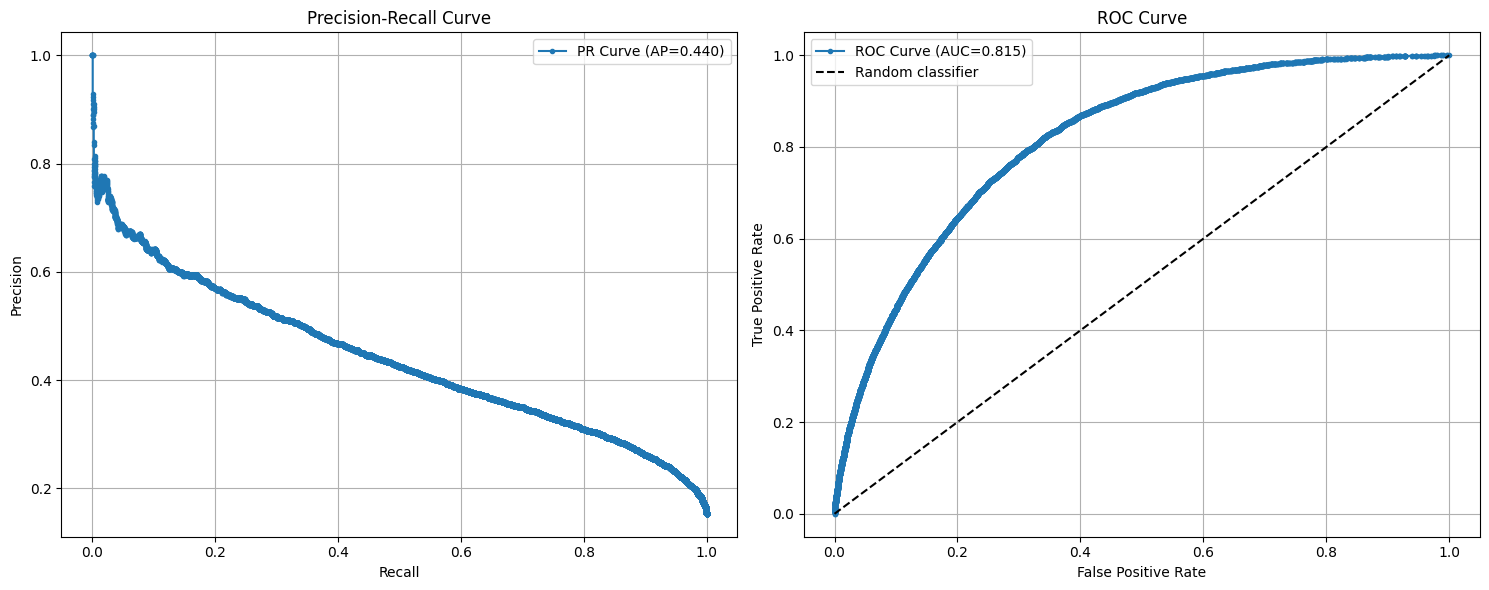

Model evaluation curves saved as '03_model_evaluation_curves.png'


In [72]:
# ============================================================================
# 6. FOCUS ON DIABETES DETECTION (CLASS 1)
# ============================================================================
print("\n" + "="*80)
print("FOCUS ON DIABETES DETECTION (CLASS 1)")
print("="*80)

precision, recall, thresholds_pr = precision_recall_curve(target_test, best_y_proba)
avg_precision = average_precision_score(target_test, best_y_proba)
fpr, tpr, thresholds_roc = roc_curve(target_test, best_y_proba)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, marker='.', label=f'PR Curve (AP={avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, marker='.', label=f'ROC Curve (AUC={model_results[best_model_name]["auc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('03_model_evaluation_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("Model evaluation curves saved as '03_model_evaluation_curves.png'")

# Decision Curve Analysis (DCA)


DECISION CURVE ANALYSIS (DCA)
Optimal threshold (max net benefit): 0.010
Maximum net benefit (DCA): 0.144802


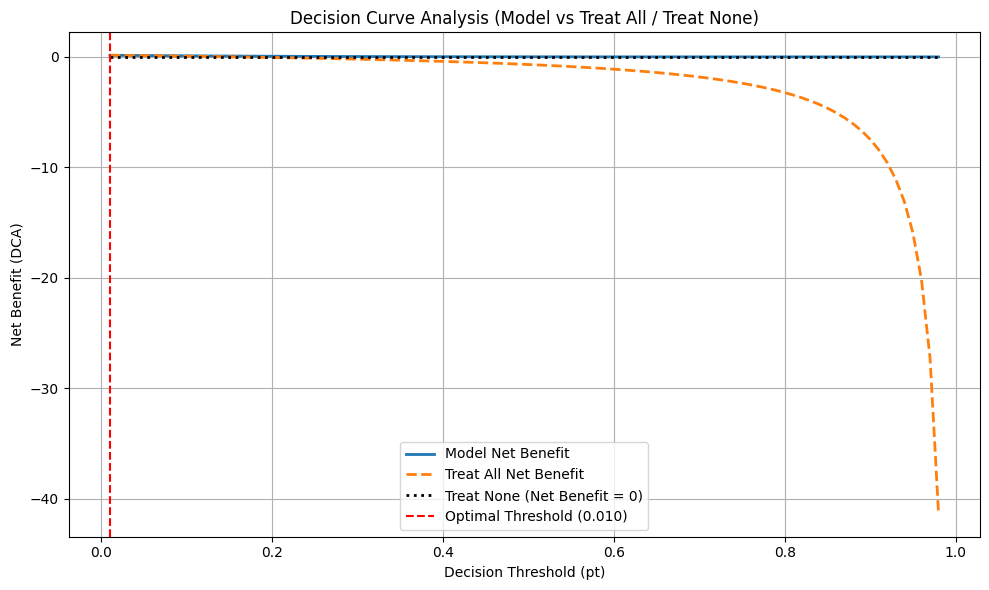

Decision Curve Analysis plot saved as '03_decision_curve_analysis.png'

Confusion matrix at optimal threshold:
[[ 3603 35273]
 [   17  7002]]
DCA results saved to C:\Users\Eyyub\Desktop\StackFuel\PortfolioProjekt\DPP-Stackfuel-Data-Science-Projekt\models\dca_results.pkl


In [73]:
# ============================================================================
# 7. DECISION CURVE ANALYSIS (DCA)
# ============================================================================
"""
Decision Curve Analysis (DCA) — explanation and usage.

DCA purpose
-----------
Decision Curve Analysis (DCA) is a method to evaluate the clinical usefulness of
a diagnostic or predictive model across a range of decision thresholds without
requiring explicit monetary valuations. DCA computes a 'net benefit' for each
threshold (probability cut-off) that reflects the trade-off between true
positives and false positives at that threshold.

DCA formula
-----------
For a given threshold pt, and sample size N:
    net_benefit(pt) = (TP / N) - (FP / N) * (pt / (1 - pt))

Interpretation
--------------
- TP: number of true positives at threshold pt
- FP: number of false positives at threshold pt
- The factor (pt / (1 - pt)) is the odds at threshold pt and represents the relative
  weight of a false positive compared to a true positive implied by choosing pt.
- Net benefit is measured in "true positives per patient" scaled by the threshold
  weights; it is not a monetary value.
- A model is clinically useful at a threshold pt if its net benefit is higher
  than the net benefit of the two default strategies:
    - Treat none (net benefit = 0)
    - Treat all (net benefit computed by assuming everyone is treated)

Practical notes
---------------
- Use DCA when you care about the clinical decision trade-offs (e.g. whether to
  refer for further testing, start treatment) and you want a threshold-agnostic view.
- DCA does NOT replace domain-specific judgement. Report thresholds of interest
  and, if desired, supplement with sensitivity analyses.
- This implementation additionally plots the 'treat all' and 'treat none'
  strategies for comparison, and returns the threshold with the maximum net benefit.
"""
print("\n" + "="*80)
print("DECISION CURVE ANALYSIS (DCA)")
print("="*80)

# Compute DCA net benefit for a model's predicted probabilities
def compute_decision_curve(y_true, y_proba, thresholds):
    """
    Compute net benefit for each threshold following DCA formula.

    Args:
        y_true (array-like): true binary labels (0/1).
        y_proba (array-like): predicted probabilities for the positive class.
        thresholds (array-like): list/array of thresholds to evaluate.

    Returns:
        dict: {
            'thresholds': thresholds (np.array),
            'net_benefits': np.array of model net benefits,
            'net_benefit_treat_all': np.array of treat-all net benefits,
            'net_benefit_treat_none': np.array of treat-none net benefits (zeros)
        }
    """
    N = len(y_true)
    net_benefits = []
    net_benefits_all = []
    net_benefits_none = []

    # Precompute counts for the treat-all strategy
    # If we "treat all", TP = number of positives, FP = number of negatives
    total_positives = np.sum(y_true == 1)
    total_negatives = np.sum(y_true == 0)

    for pt in thresholds:
        # Predicted positive/negative labels at threshold pt
        y_pred = (y_proba >= pt).astype(int)

        # Confusion matrix values: tn, fp, fn, tp
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        # DCA net benefit for the model at pt
        # Formula: (TP / N) - (FP / N) * (pt / (1 - pt))
        weight = pt / (1.0 - pt)
        nb_model = (tp / N) - (fp / N) * weight
        net_benefits.append(nb_model)

        # DCA net benefit for the treat-all strategy at pt
        nb_all = (total_positives / N) - (total_negatives / N) * weight
        net_benefits_all.append(nb_all)

        # Treat-none has net benefit = 0 for all thresholds
        net_benefits_none.append(0.0)

    return {
        'thresholds': np.array(thresholds),
        'net_benefits': np.array(net_benefits),
        'net_benefit_treat_all': np.array(net_benefits_all),
        'net_benefit_treat_none': np.array(net_benefits_none)
    }

# Range of thresholds to evaluate (fine grid)
thresholds_to_test = np.arange(0.01, 0.99, 0.01)

# Compute decision curves using the best model probabilities (best_y_proba) and test labels (target_test)
dca_results = compute_decision_curve(target_test, best_y_proba, thresholds_to_test)

# Find optimal threshold that maximizes net benefit for the model
optimal_idx = np.nanargmax(dca_results['net_benefits'])
optimal_threshold = dca_results['thresholds'][optimal_idx]
optimal_net_benefit = dca_results['net_benefits'][optimal_idx]

print(f"Optimal threshold (max net benefit): {optimal_threshold:.3f}")
print(f"Maximum net benefit (DCA): {optimal_net_benefit:.6f}")

# Plot Decision Curve: model vs treat-all vs treat-none
plt.figure(figsize=(10, 6))
plt.plot(dca_results['thresholds'], dca_results['net_benefits'],
         label='Model Net Benefit', color='C0', linewidth=2)
plt.plot(dca_results['thresholds'], dca_results['net_benefit_treat_all'],
         label='Treat All Net Benefit', color='C1', linestyle='--', linewidth=2)
plt.plot(dca_results['thresholds'], dca_results['net_benefit_treat_none'],
         label='Treat None (Net Benefit = 0)', color='k', linestyle=':', linewidth=2)

# Mark optimal threshold on the plot
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.3f})')

plt.xlabel('Decision Threshold (pt)')
plt.ylabel('Net Benefit (DCA)')
plt.title('Decision Curve Analysis (Model vs Treat All / Treat None)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

# Save the DCA plot
plt.savefig('03_decision_curve_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("Decision Curve Analysis plot saved as '03_decision_curve_analysis.png'")

# Print confusion matrix at optimal threshold for interpretability
y_pred_optimal = (best_y_proba >= optimal_threshold).astype(int)
cm_optimal = confusion_matrix(target_test, y_pred_optimal)
print("\nConfusion matrix at optimal threshold:")
print(cm_optimal)

# Save the optimal threshold and DCA results into the models/results folder
dca_save_path = models_dir / 'dca_results.pkl'

# Save a compact DCA summary (thresholds, net_benefits, optimal threshold)
joblib.dump({
    'thresholds': dca_results['thresholds'],
    'net_benefits': dca_results['net_benefits'],
    'net_benefit_treat_all': dca_results['net_benefit_treat_all'],
    'optimal_threshold': float(optimal_threshold),
    'optimal_net_benefit': float(optimal_net_benefit)
}, dca_save_path)
print(f"DCA results saved to {dca_save_path}")

# Feature Importance


FEATURE IMPORTANCE
Top 10 Most Important Features:
 1. HighBP_1                      : 0.6157
 2. DiffWalk_1                    : 0.0331
 3. HighChol_1                    : 0.0271
 4. NoDocbcCost_1                 : 0.0239
 5. Smoker_1                      : 0.0234
 6. Age                           : 0.0184
 7. GenHlth_1                     : 0.0178
 8. GenHlth_2                     : 0.0177
 9. CholCheck_1                   : 0.0165
10. HvyAlcoholConsump_0           : 0.0127


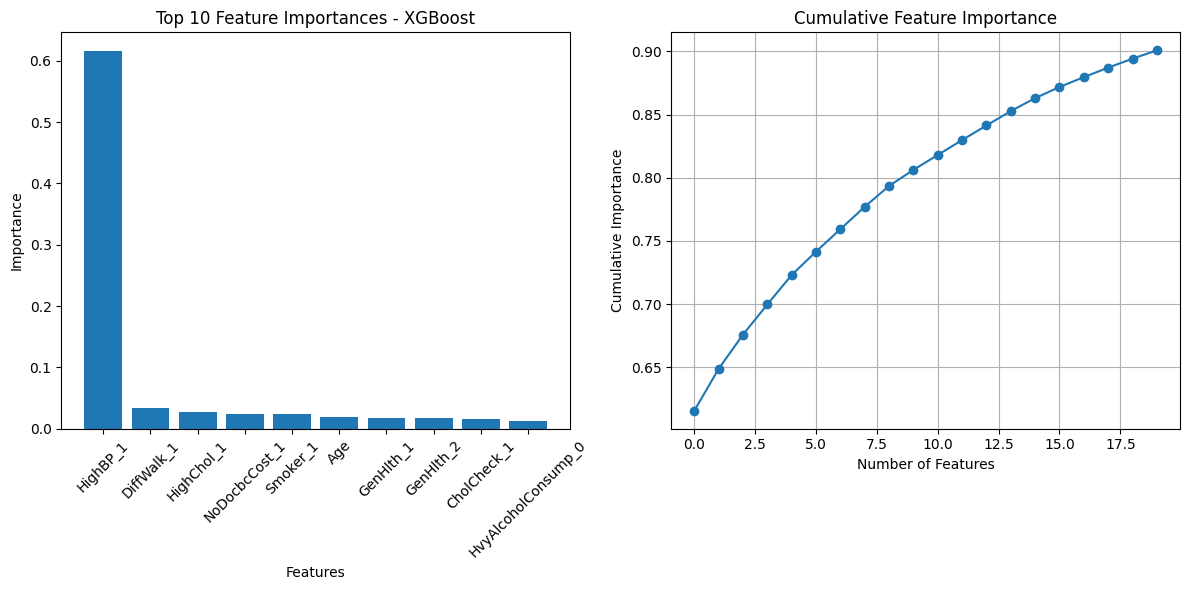

Extended feature importance plot saved as '03_feature_importance_extended.png'


In [74]:
# ============================================================================
# 8. FEATURE IMPORTANCE
# ============================================================================
print("\n" + "="*80)
print("FEATURE IMPORTANCE")
print("="*80)

if hasattr(best_model, 'feature_importances_'):
    feature_names = feature_names_original
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    print("Top 10 Most Important Features:")
    for i in range(min(10, len(feature_names))):
        print(f"{i+1:2d}. {feature_names[indices[i]]:30s}: {importances[indices[i]]:.4f}")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"Top 10 Feature Importances - {best_model_name}")
    plt.bar(range(min(10, len(feature_names))), importances[indices[:10]], align="center")
    plt.xticks(range(min(10, len(feature_names))),
               [feature_names[indices[i]] for i in range(min(10, len(feature_names)))],
               rotation=45)
    plt.xlabel("Features")
    plt.ylabel("Importance")

    plt.subplot(1, 2, 2)
    cumulative_importance = np.cumsum(importances[indices])
    plt.plot(cumulative_importance[:min(20, len(cumulative_importance))], marker='o')
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Importance')
    plt.title('Cumulative Feature Importance')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('03_feature_importance_extended.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Extended feature importance plot saved as '03_feature_importance_extended.png'")

# Model Comparisons


MODEL COMPARISON
Model Comparison (sorted by F1):
              Model      AUC  Precision   Recall       F1  Accuracy  CV_Mean   CV_Std  Best_Threshold
            XGBoost 0.815416   0.370106 0.642399 0.469639  0.778102 0.955454 0.084821        0.260960
Logistic Regression 0.808352   0.378504 0.602080 0.464804  0.787951 0.814162 0.004848        0.634490
                SVM 0.808368   0.369580 0.624163 0.464261  0.779693 0.813863 0.004840        0.618986
        Naive Bayes 0.762289   0.311205 0.684570 0.427891  0.720035 0.765136 0.004387        0.950891
     Neural Network 0.769980   0.324482 0.609346 0.423465  0.746247 0.896743 0.062392        0.422415
      Random Forest 0.763384   0.323888 0.597663 0.420109  0.747663 0.970707 0.054398        0.270000
K-Nearest Neighbors 0.715296   0.278787 0.629862 0.386502  0.694193 0.913865 0.005007        0.600000
      Decision Tree 0.592259   0.287119 0.336943 0.310042  0.770650 0.847284 0.120161        1.000000


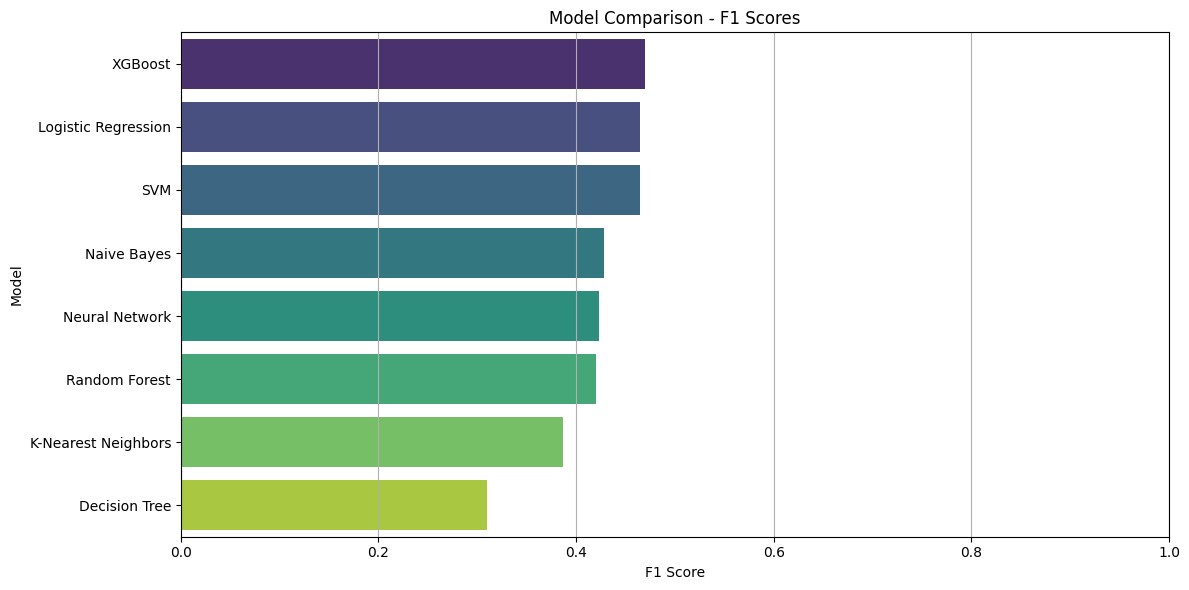

Model comparison plot saved as '03_model_comparison.png'


In [75]:
# ============================================================================
# 9. MODEL COMPARISON
# ============================================================================
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

comparison_data = []
for name, results in model_results.items():
    comparison_data.append({
        'Model': name,
        'AUC': results['auc'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1': results['f1'],
        'Accuracy': results['accuracy'],
        'CV_Mean': results['cv_mean'],
        'CV_Std': results['cv_std'],
        'Best_Threshold': results['best_threshold']
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('F1', ascending=False)
print("Model Comparison (sorted by F1):")
print(comparison_df.to_string(index=False))

plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_df, x='F1', y='Model', palette='viridis')
plt.title('Model Comparison - F1 Scores')
plt.xlabel('F1 Score')
plt.xlim(0, 1)
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig('03_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Model comparison plot saved as '03_model_comparison.png'")

# Neural Network Analysis


NEURAL NETWORK ANALYSIS
Neural Network Architecture:
  Hidden layers: (100,)
  Activation function: relu
  Alpha (regularization): 0.001
  Learning rate: constant
  Number of iterations: 96


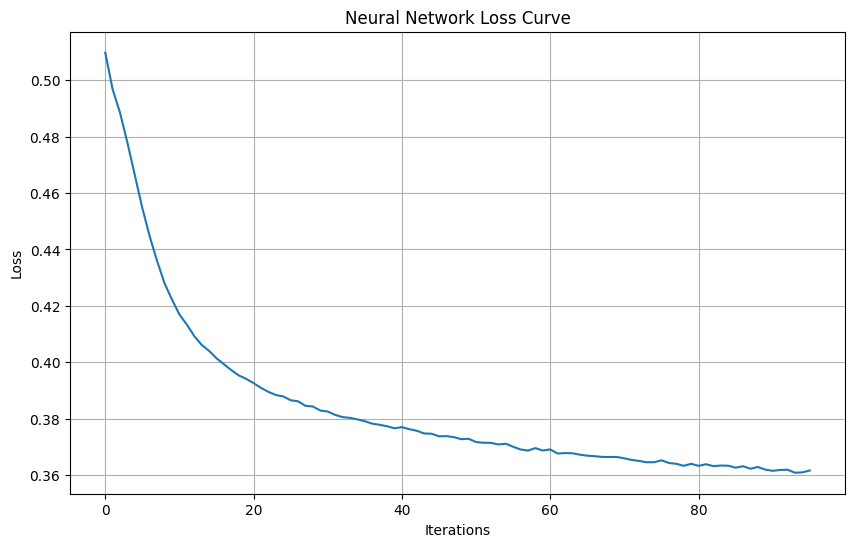

Neural network loss curve saved as '03_nn_loss_curve.png'


In [76]:
# ============================================================================
# 10. NEURAL NETWORK ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("NEURAL NETWORK ANALYSIS")
print("="*80)

nn_model = trained_models.get('Neural Network')
if nn_model:
    print("Neural Network Architecture:")
    print(f"  Hidden layers: {getattr(nn_model, 'hidden_layer_sizes', 'N/A')}")
    print(f"  Activation function: {getattr(nn_model, 'activation', 'N/A')}")
    print(f"  Alpha (regularization): {getattr(nn_model, 'alpha', 'N/A')}")
    print(f"  Learning rate: {getattr(nn_model, 'learning_rate', 'N/A')}")
    print(f"  Number of iterations: {getattr(nn_model, 'n_iter_', 'N/A')}")

    if hasattr(nn_model, 'loss_curve_'):
        plt.figure(figsize=(10, 6))
        plt.plot(nn_model.loss_curve_)
        plt.title('Neural Network Loss Curve')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.savefig('03_nn_loss_curve.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Neural network loss curve saved as '03_nn_loss_curve.png'")


# Summary and Recommendations

In [79]:
# ============================================================================
# 11. SUMMARY AND RECOMMENDATIONS
# ============================================================================
print("\n" + "="*80)
print("SUMMARY AND RECOMMENDATIONS")
print("="*80)

# Detailed English explanation about "Net Benefit" (Decision Curve Analysis)
net_benefit_explanation = """
Decision Curve Analysis (DCA) — Detailed explanation of "Net Benefit"

Definition and purpose
----------------------
Net Benefit (NB) is a decision-analytic metric used to evaluate the clinical
usefulness of a diagnostic or predictive model across a range of probability
thresholds. It quantifies a model's ability to net more true positive
decisions while accounting for the harm of false positives.

Mathematical formula
--------------------
For a given threshold pt and sample size N:

    NB(pt) = (TP / N) - (FP / N) * (pt / (1 - pt))

where:
- TP = number of true positives at threshold pt
- FP = number of false positives at threshold pt
- pt = decision threshold (probability cut-off)
- N = total number of subjects

Interpretation
--------------
- Net Benefit is measured in "true positives per patient" after penalizing
  false positives by the odds implied by the chosen threshold.
- A larger NB means that, at that threshold, the model yields more clinically
  useful decisions than competing strategies.
- NB is not a monetary value, despite sometimes being shown with a currency
  symbol for emphasis. It is dimensionless and should be read as the net
  proportion (or rate) of true-positive decisions per patient.

Comparisons and baselines
-------------------------
- "Treat none" strategy has NB = 0 for all thresholds.
- "Treat all" strategy's NB is (prevalence) - (1 - prevalence) * (pt / (1 - pt)).
- A model is considered clinically useful at threshold pt if its NB exceeds
  both the "treat none" and "treat all" strategies.

Practical notes
---------------
- NB depends on the selected threshold; inspect NB across a reasonable range
  of thresholds to understand where the model is useful.
- Use NB to choose thresholds that balance identifying cases (sensitivity)
  with avoiding unnecessary interventions (specificity), tailored to
  clinical priorities.
- NB is complementary to conventional metrics (AUC, precision, recall, F1).
  It provides decision-centric insight rather than pure discrimination.

Reporting
---------
- Report NB values with the threshold at which they were computed.
- When communicating improvements (e.g., "net benefit improvement: 0.1448"),
  interpret as an increase in weighted true-positive decisions per patient,
  not as currency or direct monetary gain.

Caveats
------
- NB assumes the relative harms of FP vs FN implicit in the threshold pt.
- Always complement DCA with clinical reasoning, costs, and downstream effects.

"""

# Print the explanatory block (optional; keeps the code self-documenting at runtime)
print(net_benefit_explanation)

# Print a concise summary (no dollar sign; net benefit is dimensionless)
print(f"Best performing model (by F1): {best_model_name}")
print(f"F1 Score: {model_results[best_model_name]['f1']:.4f}")
print(f"Optimal threshold for diabetes detection: {best_threshold:.3f}")
print(f"Net benefit improvement: {optimal_net_benefit:.4f}")  # removed $

print("\nKey Findings:")
print(f"1. {best_model_name} achieved the highest F1 score of {model_results[best_model_name]['f1']:.4f}")
print(f"2. Optimal threshold ({best_threshold:.3f}) provides better cost-benefit than default (0.5)")
print(f"3. Net benefit improved by {optimal_net_benefit:.4f} with optimal threshold")
if 'Neural Network' in model_results:
    print(f"4. Neural Network achieved F1 of {model_results['Neural Network']['f1']:.4f}")

print("\nRecommendations:")
print("1. Use the optimal threshold for deployment to maximize decision-centered benefit")
print("2. Consider the best model for production based on both performance and interpretability")
if 'Neural Network' in model_results:
    nn_f1 = model_results['Neural Network']['f1']
    best_non_nn = max([(name, results['f1']) for name, results in model_results.items() if name != 'Neural Network'], key=lambda x: x[1])
    if nn_f1 > best_non_nn[1]:
        print("3. Neural Network outperformed traditional models - consider for deployment")
    else:
        print("3. Traditional models outperformed Neural Network - consider for deployment")
print("4. Monitor model performance regularly, especially for class 1 (diabetes) detection")
print("5. Consider ensemble methods to further improve performance if needed")


SUMMARY AND RECOMMENDATIONS

Decision Curve Analysis (DCA) — Detailed explanation of "Net Benefit"

Definition and purpose
----------------------
Net Benefit (NB) is a decision-analytic metric used to evaluate the clinical
usefulness of a diagnostic or predictive model across a range of probability
thresholds. It quantifies a model's ability to net more true positive
decisions while accounting for the harm of false positives.

Mathematical formula
--------------------
For a given threshold pt and sample size N:

    NB(pt) = (TP / N) - (FP / N) * (pt / (1 - pt))

where:
- TP = number of true positives at threshold pt
- FP = number of false positives at threshold pt
- pt = decision threshold (probability cut-off)
- N = total number of subjects

Interpretation
--------------
- Net Benefit is measured in "true positives per patient" after penalizing
  false positives by the odds implied by the chosen threshold.
- A larger NB means that, at that threshold, the model yields more clinically